In [1]:
from pysap.plugins.mri.reconstruct_3D.fourier import NUFFT, NFFT3, FFT3
import numpy as np
from pysap.plugins.mri.reconstruct_3D.utils import convert_mask_to_locations_3D

/home/bs255482/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@gmail.com>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

future         : >=0.16.0  - required | 0.16.0    installed
matplotlib     : >=2.1.2   - required | 2.2.2     installed
modopt         : >=1.1.4   - required | 1.1.5     installed
scipy          : >=1.0.0   - required | 1.1.0     installed
pysparse       : >=0.0.1   - required | 0.0.1     installed
nibabel        : >=2.1.0   - required | 2.2.1     installed
progressbar    : >=3.34.3  - required | 3.37.1    installed
numpy          : >=1.11.0  - required | 1.14.5    installed
astropy        : ==2.0.4   - re

In [2]:
_mask = np.ones(np.random.randint(2, size=(64,64,64)).shape)
_samples = convert_mask_to_locations_3D(_mask)
_samples_shift = convert_mask_to_locations_3D(np.fft.fftshift(_mask))
image = np.load('/volatile/bsarthou/datas/NUFFT/mri_img_2D.npy')
image = image[64:128, 64:128]
images = np.tile(image, (64,1,1))

In [3]:
fourier_op_dir_nufft = NUFFT(samples=_samples, platform='cpu', shape=(64,64,64), Kd=64, Jd=3)
fourier_op_dir_nfft = NFFT3(samples=_samples, shape=(64,64,64))

Creating the NUFFT object...


In [4]:
fourier_op_dir_fft = FFT3(samples=_samples_shift, shape=(64,64,64))

In [5]:
kspace_nfft = fourier_op_dir_nfft.op(images)# *(1./np.sqrt(64*64*64))
kspace_nufft = fourier_op_dir_nufft.op(images)
kspace_fft = np.fft.ifftshift(fourier_op_dir_fft.op(np.fft.fftshift(images)))
kspace_fft_nufft = np.fft.ifftshift(fourier_op_dir_fft.op(images))
kspace_fft_nufft = kspace_fft_nufft.flatten()
kspace_fft = kspace_fft.flatten()# /np.sqrt(64*64*64)

In [6]:
print(kspace_nufft.shape)
print(kspace_nfft.shape)
print(kspace_fft.shape)
idx = np.where(np.abs(kspace_fft) != 0)
print(idx[0].shape)
for xk in range(17):
    print(kspace_nufft[idx[0][xk]], kspace_fft_nufft[idx[0][xk]])

(262144,)
(262144,)
(262144,)
(4096,)
(-0.19814793606113285-2.213507155346406e-15j) (-0.19558823529411695+0j)
(-0.10316949060834013+0.305532442488714j) (0.1206313399126418-0.35447571844393605j)
(0.12787981700061046-0.10962965649367361j) (0.14082723392854796-0.15084759340651127j)
(0.09202956949031223-0.19575987856338847j) (-0.09106783514676649+0.21863053196877424j)
(-0.085759400649997+0.06355882973664424j) (-0.14188808675258002+0.021792247221910838j)
(-0.32914463504937425+0.47154183072181016j) (0.3573332710372344-0.49711576792614465j)
(-0.06454440208141332-0.009663464840821763j) (-0.04537242519650059-0.026903688135865328j)
(-0.14350287188102878+0.057336625819066595j) (0.1745657311452199-0.05361611550065737j)
(-0.33098849006515435+0.21905178187845797j) (-0.36614235857085736+0.20885166431697594j)
(-0.027678307159942777+0.1412002791646825j) (-0.04210494805545234-0.1376460881080407j)
(0.16536628961802588+0.15068675113409355j) (0.14143037510613965+0.1522039240602649j)
(0.23019598459162738-0.

In [7]:
from modopt.math.metrics import mse

print(mse(kspace_nufft, kspace_nfft))
print(mse(kspace_nufft, kspace_fft))
print(mse(kspace_nfft, kspace_fft))
print(mse(kspace_nufft, kspace_fft_nufft))

4.6721986303959946e-08
4.6721986303962275e-08
3.140976778750038e-34
4.6721986303962275e-08


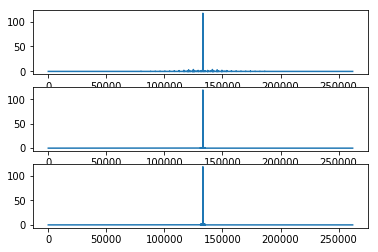

In [8]:
import matplotlib.pyplot as plt
plt.subplot(311)
plt.plot(np.abs(kspace_nufft))
plt.subplot(312)
plt.plot(np.abs(kspace_nfft))
plt.subplot(313)
plt.plot(np.abs(kspace_fft))

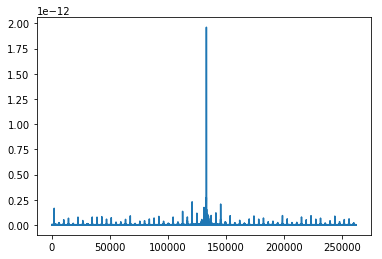

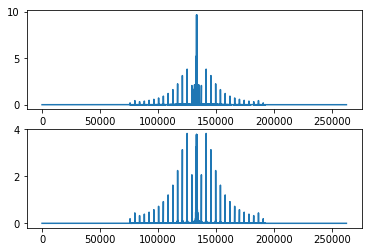

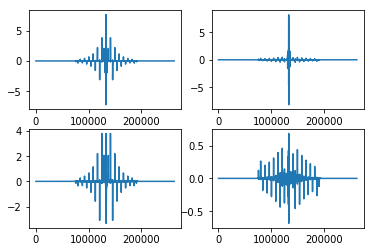

In [9]:
plt.figure()
plt.plot(np.abs(kspace_nfft - kspace_fft))

plt.figure()
plt.subplot(211)
plt.plot(np.abs(kspace_nufft - kspace_fft_nufft))
plt.subplot(212)
plt.plot(np.abs(kspace_nufft - kspace_fft))

plt.figure()
plt.subplot(221)
plt.plot(np.real(kspace_nufft - kspace_fft_nufft))
plt.subplot(222)
plt.plot(np.imag(kspace_nufft - kspace_fft_nufft))
plt.subplot(223)
plt.plot(np.real(kspace_nufft - kspace_fft))
plt.subplot(224)
plt.plot(np.imag(kspace_nufft - kspace_fft))


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.set_title('FFT vs. NFFT:\n l2={:4E}'.format(mse(kspace_fft, kspace_nfft)))
ax1.set_xlabel('Nb samples')
ax1.set_ylabel('Amplitude')
ax1.plot(np.abs(kspace_nfft - kspace_fft))

ax2.set_title('NFFT vs. NUFFT:\n l2={:4E}'.format(mse(kspace_nfft, kspace_nufft)))
ax2.set_xlabel('Nb samples')
ax2.set_ylabel('Amplitude')
ax2.plot(np.abs(kspace_nfft - kspace_nufft))

ax3.set_title('FFT vs. NUFFT:\n l2={:4E}'.format(mse(kspace_fft, kspace_nufft)))
ax3.set_xlabel('Nb samples')
ax3.set_ylabel('Amplitude')
plt.plot(np.abs(kspace_fft - kspace_nufft))
plt.tight_layout()

In [ ]:
non_z = np.nonzero(kspace_fft)
print(kspace_fft[non_z])
print(kspace_nfft[non_z])
print(kspace_nufft[non_z])

In [ ]:
kspace_input = np.copy(kspace_nfft)
fourier_op_adj_nufft = NUFFT(samples=_samples, platform='cpu', shape=(64,64,64), Kd=64, Jd=1)
fourier_op_adj_nfft = NFFT3(samples=_samples, shape=(64,64,64))
fourier_op_adj_fft = FFT3(samples=_samples_shift, shape=(64,64,64))


In [ ]:
img_nfft = fourier_op_adj_nfft.adj_op(kspace_input)
img_nufft = fourier_op_adj_nufft.adj_op(kspace_input)
#kspace_fft = kspace_fft.flatten()/np.sqrt(64*64*64)
kspace_input_fft = np.reshape(kspace_input, (64,64,64))
img_fft = np.fft.fftshift(fourier_op_adj_fft.adj_op(np.fft.ifftshift(kspace_input_fft)))

In [ ]:
print(mse(img_nufft, img_nfft))
print(mse(img_nufft, img_fft))
print(mse(img_nfft, img_fft))

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(img_nfft[:,:,10]),cmap = 'gray')
plt.subplot(122)
plt.imshow(np.abs(img_fft[:,:,10]), cmap='gray')

In [ ]:
_min, _max = np.min(np.abs(np.abs(img_nfft[:,:,10]) - np.abs(img_nufft[:,:,10]))), np.max(np.abs(np.abs(img_nfft[:,:,10]) - np.abs(img_nufft[:,:,10])))

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('FFT vs. NFFT:\n l2={:4E}'.format(mse(np.abs(img_fft[:,:,10]), np.abs(img_nfft[:,:,10]))))
ax1.set_xlabel('Nb samples')
ax1.set_ylabel('Amplitude')
ax1.imshow(np.abs(np.abs(img_nfft[:,:,10]) - np.abs(img_fft[:,:,10])), vmin=_min, vmax=_max)

ax2.set_title('NFFT vs. NUFFT:\n l2={:4E}'.format(mse(np.abs(img_nfft[:,:,10]), np.abs(img_nufft[:,:,10]))))
ax2.set_xlabel('Nb samples')
ax2.set_ylabel('Amplitude')
ax2.imshow(np.abs(np.abs(img_nfft[:,:,10]) - np.abs(img_nufft[:,:,10])), vmin=_min, vmax=_max)

ax3.set_title('FFT vs. NUFFT:\n l2={:4E}'.format(mse(np.abs(img_fft[:,:,10]), np.abs(img_nufft[:,:,10]))))
ax3.set_xlabel('Nb samples')
ax3.set_ylabel('Amplitude')
plt.imshow(np.abs(np.abs(img_nfft[:,:,10]) - np.abs(img_nufft[:,:,10])), vmin=_min, vmax=_max)
plt.tight_layout()
plt.show()